In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-19 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-29 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-22 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-30 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-18 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-20 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-24 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-23 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-28 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-25 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-26 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-17 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10)/test/7/forge/cf-007-21 (Copy).jpg
/kaggle/input/gpds-1150/New folder (10

In [5]:
import os
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Dataset Loading for GPDS-1150
def load_gpds_dataset(base_path):
    X = []
    y = []
    
    # GPDS dataset has a specific structure with folders for each signer
    # First, let's find the main folder that contains the signature folders
    for root, dirs, files in os.walk(base_path):
        # Look for folders that might contain the signatures
        for dir_name in dirs:
            if dir_name.isdigit():  # Signer folders are typically numbered
                signer_path = os.path.join(root, dir_name)
                
                # Load genuine signatures (usually named with 'G' or 'original')
                for file in os.listdir(signer_path):
                    file_lower = file.lower()
                    if file_lower.endswith(('.png', '.jpg', '.jpeg')):
                        if 'g_' in file_lower or 'original' in file_lower or 'genuine' in file_lower:
                            file_path = os.path.join(signer_path, file)
                            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                            if img is not None:
                                img = cv2.resize(img, (200, 200))
                                X.append(img)
                                y.append(0)  # 0 for genuine
                        
                        # Load forged signatures (usually named with 'F' or 'forgery')
                        elif 'f_' in file_lower or 'forg' in file_lower or 'fake' in file_lower:
                            file_path = os.path.join(signer_path, file)
                            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                            if img is not None:
                                img = cv2.resize(img, (200, 200))
                                X.append(img)
                                y.append(1)  # 1 for forged
    
    return np.array(X), np.array(y)

# 2. Feature Extraction (AIS + HOG)
def extract_ais(img, grid_size=(6, 6)):
    h, w = img.shape
    block_h, block_w = h // grid_size[0], w // grid_size[1]
    features = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            block = img[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            features.append(np.mean(block))
    return features

def extract_features(images):
    ais_features = []
    hog_features = []
    
    for img in images:
        # Preprocess - normalize and remove noise
        img = cv2.GaussianBlur(img, (3, 3), 0)
        
        # AIS features (36 features for 6x6 grid)
        ais_features.append(extract_ais(img))
        
        # HOG features
        hog_feat = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                      cells_per_block=(1, 1))
        hog_features.append(hog_feat)
    
    return np.concatenate((np.array(ais_features), np.array(hog_features)), axis=1)

# 3. Main Execution
def main():
    # Set dataset path
    dataset_path = '/kaggle/input/gpds-1150'
    
    # First, let's examine the dataset structure
    print("Dataset structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Print first 5 files only
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")
    
    # Now load the dataset
    print(f"\nLoading GPDS dataset from {dataset_path}...")
    try:
        X, y = load_gpds_dataset(dataset_path)
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return
    
    if len(X) == 0:
        print("\nNo images found! Possible solutions:")
        print("1. Check the actual path to your dataset")
        print("2. Verify the naming convention of signature files")
        print("3. Make sure files have .png, .jpg, or .jpeg extensions")
        print("\nHere's the complete directory structure:")
        for root, dirs, files in os.walk(dataset_path):
            print(root)
            for file in files:
                print(f"  - {file}")
        return
    
    print(f"\nSuccessfully loaded {len(X)} images:")
    print(f"- Genuine signatures: {np.sum(y==0)}")
    print(f"- Forged signatures: {np.sum(y==1)}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Extract features
    print("\nExtracting features...")
    X_train_features = extract_features(X_train)
    X_test_features = extract_features(X_test)
    print(f"Feature vector shape: {X_train_features.shape}")
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_test_features = scaler.transform(X_test_features)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
    
    print("\nTraining Random Forest model...")
    rf_model.fit(X_train_features, y_train)
    
    # Evaluate
    y_pred = rf_model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nModel Accuracy: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature Importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
    plt.title("Feature Importance")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Forged'],
                yticklabels=['Genuine', 'Forged'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

if __name__ == "__main__":
    main()

Dataset structure:
gpds-1150/
    New folder (10)/
        test/
            7/
                forge/
                    cf-007-19 (Copy).jpg
                    cf-007-29 (Copy).jpg
                    cf-007-22 (Copy).jpg
                    cf-007-30 (Copy).jpg
                    cf-007-18 (Copy).jpg
                    ... and 9 more files
                genuine/
                    c-007-22 (Copy).jpg
                    c-007-24 (Copy).jpg
                    c-007-18 (Copy).jpg
                    c-007-21 (Copy).jpg
                    c-007-20 (Copy).jpg
                    ... and 3 more files
            135/
                forge/
                    cf-135-30 (Copy).jpg
                    cf-135-23 (Copy).jpg
                    cf-135-18 (Copy).jpg
                    cf-135-21 (Copy).jpg
                    cf-135-28 (Copy).jpg
                    ... and 9 more files
                genuine/
                    c-135-21 (Copy).jpg
                    c-135-20 (Copy

Loading dataset from /kaggle/input/gpds-1150...

Loaded 3300 images:
- Genuine signatures: 1200
- Forged signatures: 2100

Extracting features...
Feature vector shape: (2640, 1188)

Training Random Forest model...

Model Accuracy: 78.64%

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       240
           1       0.79      0.90      0.84       420

    accuracy                           0.79       660
   macro avg       0.78      0.74      0.76       660
weighted avg       0.78      0.79      0.78       660



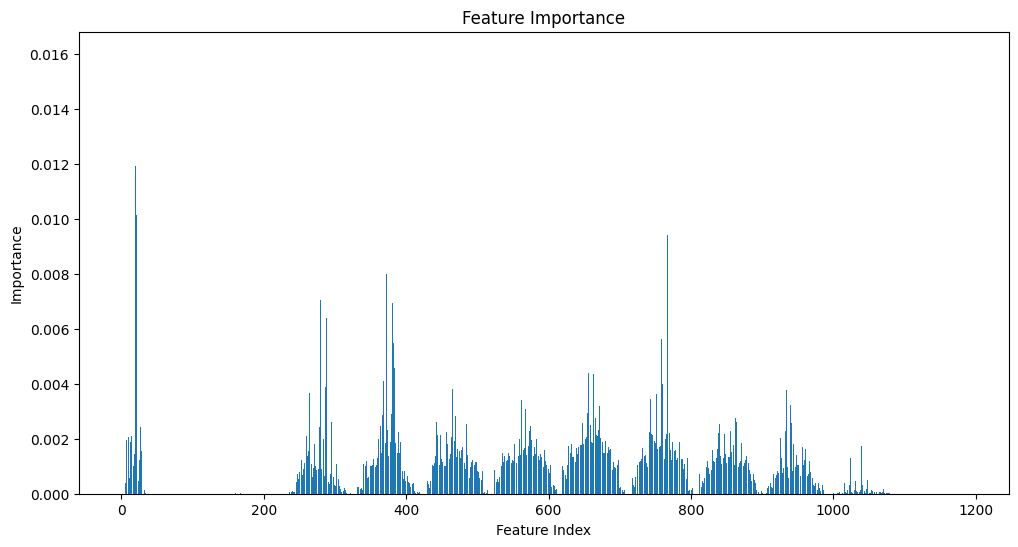

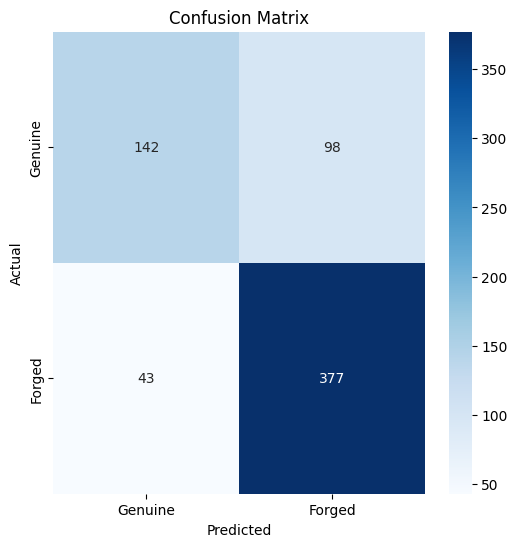

In [6]:
import os
import cv2
import joblib



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Dataset Loading for your specific structure
def load_dataset(base_path):
    X = []
    y = []
    
    # Walk through the test directory which contains signer folders
    test_path = os.path.join(base_path, "New folder (10)", "test")
    
    # Check each signer folder (7, 135, 47, etc.)
    for signer_folder in os.listdir(test_path):
        signer_path = os.path.join(test_path, signer_folder)
        
        # Skip if not a directory
        if not os.path.isdir(signer_path):
            continue
            
        # Load genuine signatures
        genuine_path = os.path.join(signer_path, "genuine")
        if os.path.exists(genuine_path):
            for file in os.listdir(genuine_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(genuine_path, file)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (200, 200))
                        X.append(img)
                        y.append(0)  # 0 for genuine
        
        # Load forged signatures
        forge_path = os.path.join(signer_path, "forge")
        if os.path.exists(forge_path):
            for file in os.listdir(forge_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(forge_path, file)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (200, 200))
                        X.append(img)
                        y.append(1)  # 1 for forged
    
    return np.array(X), np.array(y)

# 2. Feature Extraction (AIS + HOG)
def extract_ais(img, grid_size=(6, 6)):
    h, w = img.shape
    block_h, block_w = h // grid_size[0], w // grid_size[1]
    features = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            block = img[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            features.append(np.mean(block))
    return features

def extract_features(images):
    ais_features = []
    hog_features = []
    
    for img in images:
        # Preprocess - normalize and remove noise
        img = cv2.GaussianBlur(img, (3, 3), 0)
        
        # AIS features (36 features for 6x6 grid)
        ais_features.append(extract_ais(img))
        
        # HOG features
        hog_feat = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                      cells_per_block=(1, 1))
        hog_features.append(hog_feat)
    
    return np.concatenate((np.array(ais_features), np.array(hog_features)), axis=1)

# 3. Main Execution
def main():
    # Set dataset path
    dataset_path = '/kaggle/input/gpds-1150'
    
    print(f"Loading dataset from {dataset_path}...")
    try:
        X, y = load_dataset(dataset_path)
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return
    
    if len(X) == 0:
        print("No images found! Please check your dataset path and structure.")
        return
    
    print(f"\nLoaded {len(X)} images:")
    print(f"- Genuine signatures: {np.sum(y==0)}")
    print(f"- Forged signatures: {np.sum(y==1)}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Extract features
    print("\nExtracting features...")
    X_train_features = extract_features(X_train)
    X_test_features = extract_features(X_test)
    print(f"Feature vector shape: {X_train_features.shape}")
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_test_features = scaler.transform(X_test_features)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
    
    print("\nTraining Random Forest model...")
    rf_model.fit(X_train_features, y_train)
    
    # Evaluate
    y_pred = rf_model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nModel Accuracy: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature Importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
    plt.title("Feature Importance")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Forged'],
                yticklabels=['Genuine', 'Forged'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    joblib.dump(rf_model, '/kaggle/working/rf_signature_model.sav')
    joblib.dump(scaler, '/kaggle/working/scaler_signature_model.sav')

 
      


if __name__ == "__main__":
    main()